# Recommendations with IBM

In this notebook, we will be putting our recommendation skills to use on real data from the IBM Watson Studio platform. 


By following the table of contents, we will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)


In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']
df['article_id'] = df['article_id'].astype(str) # convert the article_id from float to string types
# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [65]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [66]:
# find the user article interactions 
user_article_interacts = df.groupby("email")["article_id"].count()

Text(0, 0.5, 'frequency')

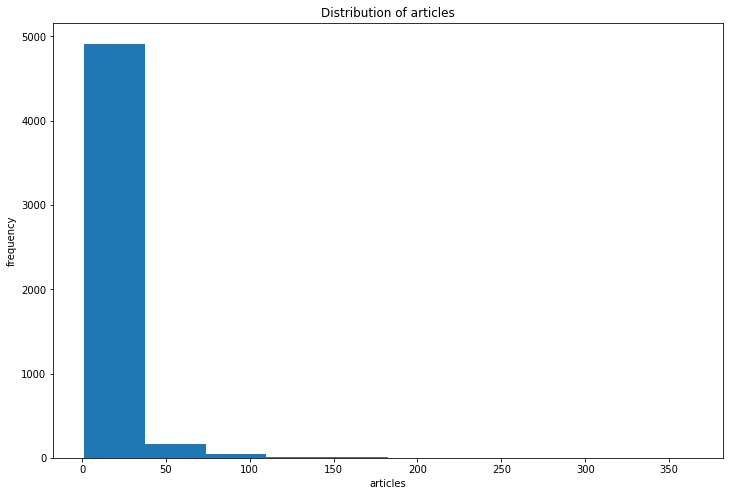

In [67]:
#plot the histogram of the article ids 
plt.figure(figsize = (12,8))
plt.hist(user_article_interacts)
plt.title("Distribution of articles")
plt.xlabel("articles")
plt.ylabel("frequency")

In [68]:
# describtibe statistics of the user-article in df data frame 
user_article_interacts.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

In [69]:
# Fill in the median and maximum number of user_article interactios below

median_val =  user_article_interacts.median()# 50% of individuals interact with ____ number of articles or fewer.
print("%50 of the users interact with {} number of articles".format(median_val))
max_views_by_user = user_article_interacts.max()# The maximum number of user-article interactions by any 1 user is ______.
print("the maximum number of user_article interactions by any user is {}".format(max_views_by_user))

%50 of the users interact with 3.0 number of articles
the maximum number of user_article interactions by any user is 364


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [70]:
# Find and explore duplicate articles
df_content = df_content.drop_duplicates(['article_id'])

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [71]:
print("number of unique articles having at least one interaction with users:  ",\
      df['article_id'].unique().shape[0]) # number of unique articles
print("number of total articls in IBM platform: ",df_content['article_id'].unique().shape[0])
print("number of unique users is:",user_article_interacts.shape[0])
print("number of user-article interactions is:",df.shape[0])

number of unique articles having at least one interaction with users:   714
number of total articls in IBM platform:  1051
number of unique users is: 5148
number of user-article interactions is: 45993


In [72]:
unique_articles =  df['article_id'].unique().shape[0] # The number of unique articles that have at least one interaction
total_articles = df_content['article_id'].unique().shape[0]# The number of unique articles on the IBM platform
unique_users = user_article_interacts.shape[0]# The number of unique users
user_article_interactions = df.shape[0]# The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

To find the most viewed article, we first find the number of the counts od the articles in article_id column and then find the index associated with the most repeated article. then we extract the title based on that index in df data frame. 

In [73]:
idx = df['article_id'].value_counts().index[0] # find id of the most viewed article
most_viewed_article = df[df.article_id==idx].iloc[0]['title']
times_viewed = df['article_id'].value_counts().iloc[0]
print("the most viewed article is : ",most_viewed_article)
print("the article {} has been viewed {} times.".format(most_viewed_article,times_viewed))

the most viewed article is :  use deep learning for image classification
the article use deep learning for image classification has been viewed 937 times.


In [74]:
# The most viewed article in the dataset as a string with one value following the decimal 
most_viewed_article_id = str(df['article_id'].value_counts().index[0])
max_views = df['article_id'].value_counts().iloc[0]# The most viewed article in the dataset was viewed how many times?

In [75]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [76]:
user_item_intercats = df.groupby("article_id")["user_id"].count()
user_item_intercats.head()

article_id
0.0       14
100.0      9
1000.0    16
1004.0     7
1006.0    14
Name: user_id, dtype: int64

### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [77]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # n top article titles which are most viewed
    ids = np.array(df['article_id'].value_counts().iloc[:n].index)
    top_articles = df[df['article_id'].isin(ids)]['title'].unique()
    
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # n top article ids which are most viewed
    top_articles = np.array(df['article_id'].value_counts().iloc[:n].index)
 
    return top_articles # Return the top article ids

In [78]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo'
 'use deep learning for image classification'
 'apache spark lab, part 1: basic concepts'
 'predicting churn with the spss random tree algorithm'
 'analyze energy consumption in buildings'
 'visualize car data with brunel'
 'use xgboost, scikit-learn & ibm watson machine learning apis'
 'gosales transactions for logistic regression model'
 'insights from new york car accident reports'
 'finding optimal locations of new store using decision optimization']
['1429.0' '1330.0' '1431.0' '1427.0' '1364.0' '1314.0' '1293.0' '1170.0'
 '1162.0' '1304.0']


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [79]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    df_new = df.copy() # copy df to avoid change in the original dataframe
    df_new['ones'] = 1 # add a column to fill the user-article interactions with value 1
    user_item = pd.pivot_table(df_new, values='ones', index='user_id',
                    columns='article_id')
    
    user_item = user_item.fillna(0).astype(int)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [80]:
## test the results
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [81]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    user_array = np.array(user_item.loc[user_id])
    dot_product = np.dot(user_array,user_item.T)

    # sort by similarity
    sorted_indices = np.argsort(dot_product)[::-1]
    

    # create list of just the ids
    ids_list = np.array(user_item.iloc[sorted_indices].index)
   
    # remove the own user's id
    most_similar_users = np.delete(ids_list,np.where(ids_list==user_id))
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [82]:
# Do a spot check of our function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933   23 3782  203 4459  131 3870   46 4201 5041]
The 5 most similar users to user 3933 are: [   1   23 3782 4459  203]
The 3 most similar users to user 46 are: [4201   23 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [83]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # find the article names by title
    article_names = df[df['article_id'].isin(article_ids)]['title'].unique() 
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # article ids seen by user
    article_ids = np.array(user_item.loc[user_id][user_item.loc[user_id]==1].index)
    # article names seen by same user
    article_names = get_article_names(article_ids)
    
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    most_similar_users = find_similar_users(user_id) # find similar users for the specified user
    seen_articles = np.array(user_item.loc[user_id][user_item.loc[user_id]==1].index)
    recs = []
    for user in most_similar_users:
        article_ids = get_user_articles(user)[0] # get the ids of articles from the list of most similar users
        article_ids = np.setdiff1d(article_ids,seen_articles) # exclude article)ids seen by the user
        recs.extend(article_ids)
       
        # check that if number  recommended ids exceeds the threshod m
        if len(recs)>m: 
            break
       
    return recs[:10] # return your recommendations for this user_id    

In [84]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

array(['analyze energy consumption in buildings',
       'analyze accident reports on amazon emr spark',
       '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
       '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
       'data tidying in data science experience',
       'airbnb data for analytics: vancouver listings',
       'recommender systems: approaches & algorithms',
       'airbnb data for analytics: mallorca reviews',
       'analyze facebook data using ibm watson and watson studio',
       'a tensorflow regression model to predict house values'],
      dtype=object)

In [85]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("Nice job!")

Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [86]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # compute similarity of each user to the provided user
    
    # define neighbors_df data frame with specified columns and index of users 
    neighbors_df = pd.DataFrame(index = user_item.index,columns = ["similarity","num_interactions"])
    
   
    # measure the similarity between user_id and other users
    user_array = np.array(user_item.loc[user_id])
    similarity = np.dot(user_array,user_item.T)
    
    # find the articles seen by each user  
    num_interactions = df.groupby("user_id")["article_id"].count()

    
    # add the simiarity measure and num_interactions to their associated columns in neighbors_df
    neighbors_df['similarity'] = similarity
    neighbors_df['num_interactions']=num_interactions
    
    # drop the user_id from dataframe as we don't need the similarity with itself
    neighbors_df = neighbors_df.drop(user_id)
    
    # sort neighbors_df based on similarity and num_interactions
    neighbors_df = neighbors_df.sort_values(by = ["similarity","num_interactions"],ascending = False)
    
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    top_sorted_users = get_top_sorted_users(user_id)
    
    # find the articles that are already seen by user
    seen_articles = np.array(user_item.loc[user_id][user_item.loc[user_id]==1].index)
    
    recs =[]

    for user in top_sorted_users.index:
        article_ids = get_user_articles(user)[0] # get the ids of articles from the list of most similar users
        article_ids = np.setdiff1d(article_ids,seen_articles) # exclude article ids seen by the user
        recs.extend(article_ids) # put the ids in the list 
        
        # if number of reccommendations exceeds m then stop recommending more
        if len(recs) > m: 
            break
    
    rec_names = get_article_names(recs) # find the name of the articles recommended
    
    return recs[:m], rec_names[:m] # return top m 

In [87]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1024.0', '1085.0', '109.0', '1150.0', '1151.0', '1152.0', '1153.0', '1154.0', '1157.0', '1160.0']

The top 10 recommendations for user 20 are the following article names:
['ml optimization using cognitive assistant'
 'deploy your python model as a restful api'
 'apache spark lab, part 1: basic concepts'
 'timeseries data analysis of iot events by using jupyter notebook'
 'dsx: hybrid mode' 'predicting churn with the spss random tree algorithm'
 'analyze energy consumption in buildings'
 'ibm watson facebook posts for 2015'
 'use xgboost, scikit-learn & ibm watson machine learning apis'
 'apache spark lab, part 3: machine learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [88]:
### Tests with a dictionary of results
user1_most_sim = get_top_sorted_users(user_id = 1).index[0]# Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(user_id= 131).index[9] # Find the 10th most similar user to user 131
print("The user that is most similar to user 1.: ",user1_most_sim)
print("The user that is the 10th most similar to user 131: ",user131_10th_sim)

The user that is most similar to user 1.:  3933
The user that is the 10th most similar to user 131:  242


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Because the new user has no intercations with any article, so if we use our user-user based recommendation(content_based) we would no be able to provide any recommendations, as there is no similarities beween this user and the other old ones. So, we have to use the top popular articles which is knowledge based reccomendation.**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [89]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 

new_user_recs = get_top_article_ids(10)# Your recommendations here

In [90]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("Nice job!")

Nice job!


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [91]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [92]:
# quick look at the matrix
user_item_matrix.shape

(5149, 714)

`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [93]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix)# use the built in to get the three matrices

In [94]:
s.shape,u.shape,vt.shape

((714,), (5149, 5149), (714, 714))

### Provide your response here.

**In this problem, the user_item matrix contains 0 and 1 values which means whether we recommend that article to the user or not. Moreover, we have filled nan values with zero as those articles are not seen by user and the ones are seen by user we put zero.**

**So, here it makes sense to create a user_item matrix with no nan value at all, otherwise we can not use SVD. So, in this particular project we can use SVD decomposition, as we don't have any nan or empty space in the user_item matrix.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

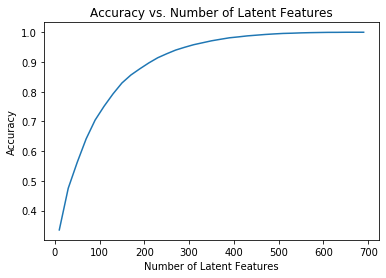

In [95]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [96]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = np.array(user_item_test.index)
    test_arts = np.array(user_item_test.columns)
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [97]:
test_predictions =  len(user_item_train[user_item_train.index.isin(test_idx)])
print("number of users we can make prdictions in test data: ",test_predictions )
print("number of users we can not make predictions in test data: ",len(test_idx) - test_predictions)
article_predictions = user_item_train.columns.isin(test_arts).sum()
print("number of articles we can make predictions in test data: ",article_predictions)
print("number of articles we can not make predictions in test data: ",len(test_arts) - article_predictions)

number of users we can make prdictions in test data:  20
number of users we can not make predictions in test data:  662
number of articles we can make predictions in test data:  574
number of articles we can not make predictions in test data:  0


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [98]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)# fit svd similar to above then use the cells below

In [99]:
u_train.shape,s_train.shape, vt_train.shape # shape of each matrix

((4487, 4487), (714,), (714, 714))

In [100]:
# we can choose the number of latent features as the length of the test data article numbers
latent_features = len(test_arts)
u_train_new = u_train[:,:latent_features] # modify u_train for new features 
s_train_new = np.diag(s_train[:latent_features]) # modify s_train for new features 
vt_train_new = vt_train[:latent_features,:] # modify vt_train for new features
print("after putting the latent features and modifying the SVD componeent matrics, the shapes are following:")
u_train_new.shape,s_train_new.shape, vt_train_new.shape # size of each matrix

after putting the latent features and modifying the SVD componeent matrics, the shapes are following:


((4487, 574), (574, 574), (574, 714))

In [101]:
# take dot product for predixtion of the test
user_item_est = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
print("the estimated user item matrix using SVD has dimensions:  ",user_item_est.shape)

the estimated user item matrix using SVD has dimensions:   (4487, 714)


Now as we can just reccommend for 20 users and 574 articles from test data,we need to fine train data and test data for those users and articles to make predictions:

In [102]:
# define dataframe for estimated user_item matrix with users and articles included in the matrix as index and column
user_item_mat = pd.DataFrame(user_item_est,index=user_item_train.index,columns = user_item_train.columns)

# find the users in train data that exist in the test data as well
user_item_intersect = user_item_mat[user_item_mat.index.isin(test_idx)]

# find the articles in train data that exist in test data as well
user_item_intersect = user_item_intersect[test_arts]

# prediction results for the test data 
user_item_intersect.head()

article_id,0.0,100.0,1000.0,1006.0,1008.0,101.0,1014.0,1016.0,1017.0,1018.0,...,973.0,975.0,977.0,98.0,981.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
2917,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,1.0,-0.0,-0.0,...,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0
3024,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,...,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0
3093,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,1.0,-0.0,...,-0.0,-0.0,0.0,0.0,0.0,-0.0,1.0,0.0,-0.0,0.0
3193,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,...,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0
3527,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,...,-0.0,1.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0


In [103]:
# repeat for the test data and  refine for predictable users and articles 
test_intersect = user_item_test[user_item_test.index.isin(user_item_intersect.index)]
test_intersect.head()

article_id,0.0,100.0,1000.0,1006.0,1008.0,101.0,1014.0,1016.0,1017.0,1018.0,...,973.0,975.0,977.0,98.0,981.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
2917,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3024,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3093,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3193,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3527,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


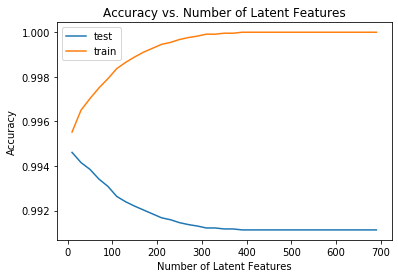

In [104]:
def plot_actual_predicted():
    """
    plot the errors asscociated with actual vs predicted values from SVD using a range of latent features 
    
    ARGS:
        None
        
    RETURNS:
        None
    """
    num_latent_feats = np.arange(10,700+10,20) # range of the latent features
    test_sum_errs = [] 
    train_sum_errs = []

    for k in num_latent_feats:
        # restructure with k latent features
        s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
        # take dot product
        user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
        # extract the test users and articles that can be predicted 
    
        # create dataframe of users and items as index and column for SVD estimated values
        user_item_mat = pd.DataFrame(user_item_est,index=user_item_train.index,columns = user_item_train.columns)
    
        # find the test users and items  that are inside the trained user_item_mat as well
        user_item_intersect = user_item_mat[user_item_mat.index.isin(test_idx)][test_arts]
    
        # filter test data for the intersect of the train and test data
        test_intersect = user_item_test[user_item_test.index.isin(user_item_intersect.index)]

        # compute error for each prediction to actual value of the test
        diffs_test = np.subtract(test_intersect, user_item_intersect)
        # total errors and keep track of them
        test_err = np.sum(np.sum(np.abs(diffs_test)))
        test_sum_errs.append(test_err)
    
        # trian error prediction
    
        # find the value of the same users and items in train data 
        train_intersect = user_item_train[user_item_train.index.isin(user_item_intersect.index)][test_arts]
        
        # compute error for each prediction to actual value of the train 
        diffs_train = np.subtract(train_intersect, user_item_intersect)
    
        # total errors and keep track of them
        train_err = np.sum(np.sum(np.abs(diffs_train)))
        train_sum_errs.append(train_err)

    # plot the errors for test data   
    plt.plot(num_latent_feats, 1 - np.array(test_sum_errs)/df.shape[0],label = "test");
    # plot the errors of the train data
    plt.plot(num_latent_feats, 1 - np.array(train_sum_errs)/df.shape[0],label = "train");

    plt.xlabel('Number of Latent Features');
    plt.ylabel('Accuracy');
    plt.title('Accuracy vs. Number of Latent Features');
    plt.legend()
    
plot_actual_predicted()

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

### Conclusions:

#### Evaluation of Results:

the accuracy for train are higher than test sets. As we increase the number of latent feature  we see that the accuracy of the train increases, while the accuracy of the test decreases. So, we can obtain higher accuracy with lower latent features. If we choose **10 features**, the result for test would be optimal. this conclusion is only right for this problem that we have 20 users to predict and 576 articles. 

#### Experiment Desighn:

we can use A/B test to make an experiment on different reccomenadtion systems we have introduced here to see how they can make improvements on finding articles for users in IBM Watson website. 

So we make an experiment on two types of reccomendation systems like user-user based collabrative filtering and matrix facorization one. the users who enter the website randomly assigned to one of these reccomendations. we  performe the experimnet for several days, and we can determine the days required by using power measure. 

The metrics we can choose to measure the effects of the reccomendations is that the total number of artciles seen by users are increased or not. So we can measure total number of views by users in each experiment and perform hypothesis test. then we can see that whether the difference between two types of reccomendations are significant or not. 



In [105]:
# create html file from the notebook file
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0